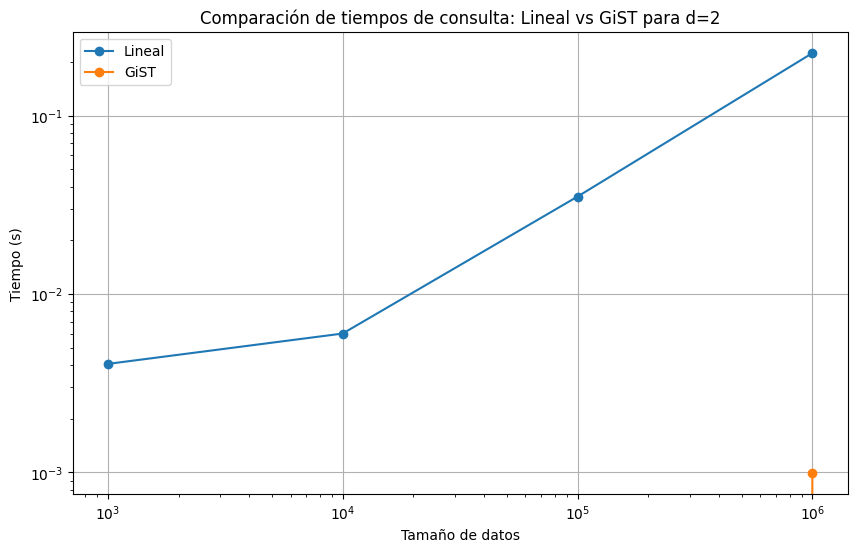

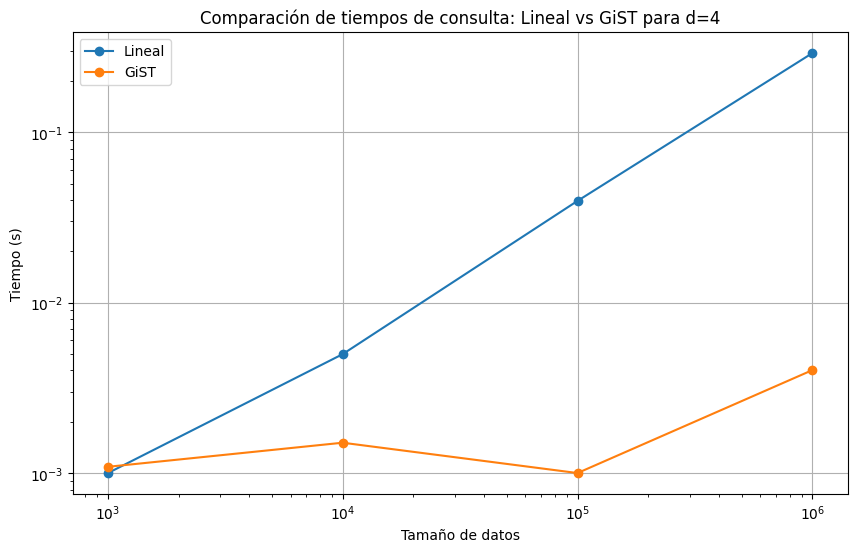

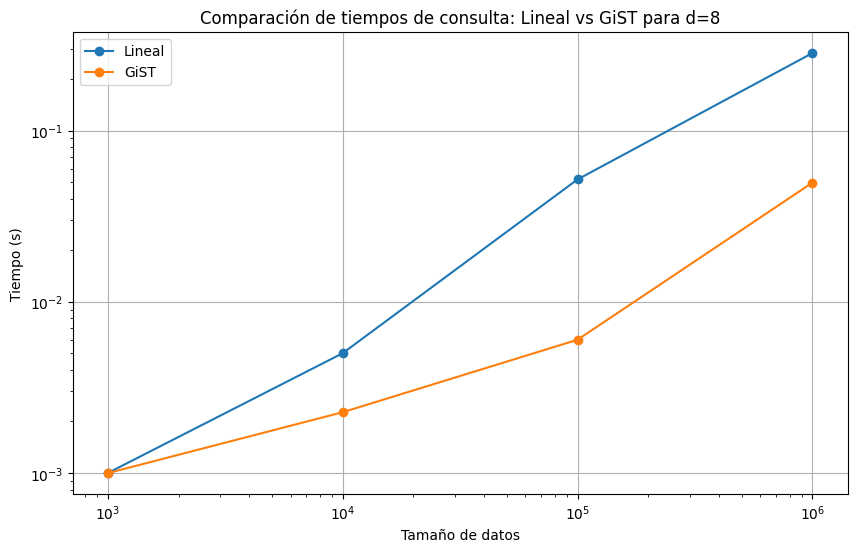

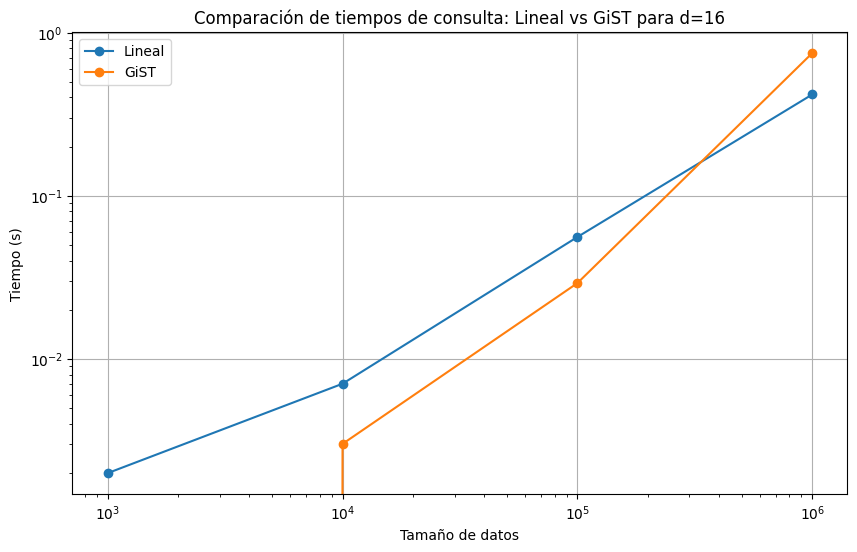

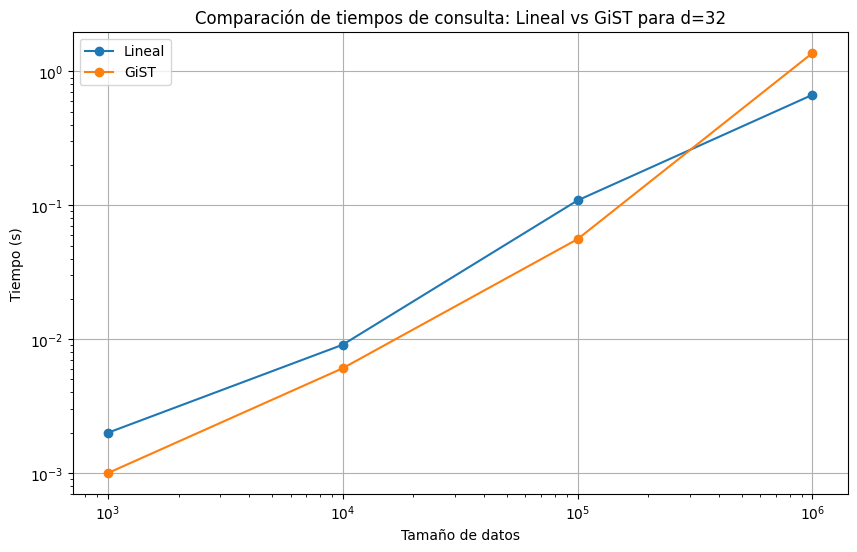

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import time

# Conéctate a la base de datos
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="1234",
    host="localhost",
    port="5432"
)

cursor = conn.cursor()

# Función para ejecutar una consulta y medir el tiempo
def execute_query(query):
    start_time = time.time()
    cursor.execute(query)
    end_time = time.time()
    return end_time - start_time

# Dimensiones a probar
dimensions = [2, 4, 8, 16, 32]
# Tamaños de datos a probar
data_sizes = [10**3, 10**4, 10**5, 10**6]

# Almacenar resultados
results = []

for d in dimensions:
    for size in data_sizes:
        # Limpia y pobla la tabla con datos aleatorios para la dimensión y tamaño actual
        cursor.execute("TRUNCATE TABLE vectors;")
        cursor.execute(f"""
        INSERT INTO vectors (id, vector)
        SELECT id,
            cube(ARRAY[{', '.join(['round(random() * 1000)' for _ in range(d)])}])
        FROM generate_series(1, {size}) id;
        """)
        cursor.execute("UPDATE vectors SET vector_idx = vector;")
        cursor.execute("DROP INDEX IF EXISTS idx_vectorind;")
        cursor.execute("CREATE INDEX idx_vectorind ON vectors USING gist(vector_idx);")

        # Consulta lineal
        lineal_time = execute_query(f"""
        EXPLAIN ANALYZE
        SELECT id, vector, cube_distance(vector, '({', '.join(['636' for _ in range(d)])})') as D
        FROM vectors
        ORDER BY vector <-> '({', '.join(['636' for _ in range(d)])})'
        LIMIT 2;
        """)

        # Consulta usando GiST
        gist_time = execute_query(f"""
        EXPLAIN ANALYZE
        SELECT id, vector_idx, cube_distance(vector_idx, '({', '.join(['636' for _ in range(d)])})') as D
        FROM vectors
        ORDER BY vector_idx <-> '({', '.join(['636' for _ in range(d)])})'
        LIMIT 2;
        """)

        # Guardar resultados
        results.append({'Dimension': d, 'Data_Size': size, 'Lineal': lineal_time, 'GiST': gist_time})

# Cerrar la conexión
cursor.close()
conn.close()

# Convertir los resultados en un DataFrame de pandas
results_df = pd.DataFrame(results)

# Graficar los resultados
for d in dimensions:
    df = results_df[results_df['Dimension'] == d]
    plt.figure(figsize=(10, 6))
    plt.plot(df['Data_Size'], df['Lineal'], label='Lineal', marker='o')
    plt.plot(df['Data_Size'], df['GiST'], label='GiST', marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Tamaño de datos')
    plt.ylabel('Tiempo (s)')
    plt.title(f'Comparación de tiempos de consulta: Lineal vs GiST para d={d}')
    plt.legend()
    plt.grid(True)
    plt.show()

